In [36]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os


In [37]:
# Define dataset path
data_dir = "./data"

# Load dataset
batch_size = 32
img_size = (160, 160)


# The Data

The dataset used in this project is available at the following link:  
[Microsoft DigiFace-1M Dataset](https://github.com/microsoft/DigiFace1M)

> The DigiFace-1M dataset is a collection of over one million diverse synthetic face images for face recognition.  
> The DigiFace-1M dataset can be used for non-commercial research.  
>   
> The dataset contains:  
>   
> - 720K images with 10K identities (72 images per identity). For each identity, 4 different sets of accessories are sampled and 18 images are rendered for each set.  
> - 500K images with 100K identities (5 images per identity). For each identity, only one set of accessories is sampled.

From the dataset, I am using 32 folders, each representing a class of 3D-rendered synthetic people. Each folder includes 71 photos captured from different angles and lighting conditions.

## Batch Size

Batch size refers to the number of images processed by the model at once. In this case, 32 images are passed through the neural network per batch.

- **Larger Batch Size**: Speeds up training but requires more memory.
- **Smaller Batch Size**: Provides better generalization but slows down training.

## Image Size

Images are resized to 160x160 pixels before being fed into the neural network. This ensures that all input images have the same dimensions for consistency.

In [38]:

train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=img_size)

# Get class names
class_names = train_dataset.class_names
print("Class names:", class_names)


Found 7272 files belonging to 101 classes.
Class names: ['0', '1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [39]:
# Normalize images
normalization_layer = layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))


In [40]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights="imagenet")

base_model.trainable = False  # Freeze the base model


In [41]:

# Create model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])


In [42]:

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 101)            │        13,029 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,434,981 (9.29 MB)

 Trainable params: 176,997 (691.39 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [43]:
epochs = 15

history = model.fit(train_dataset, epochs=epochs)


Epoch 1/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 63s 256ms/step - accuracy: 0.0224 - loss: 4.6388
Epoch 2/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 56s 246ms/step - accuracy: 0.0935 - loss: 4.0071
Epoch 3/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 54s 235ms/step - accuracy: 0.1731 - loss: 3.4235
Epoch 4/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 54s 236ms/step - accuracy: 0.2518 - loss: 2.9968
Epoch 5/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 50s 218ms/step - accuracy: 0.3158 - loss: 2.6830
Epoch 6/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 50s 219ms/step - accuracy: 0.3527 - loss: 2.5097
Epoch 7/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 51s 223ms/step - accuracy: 0.3807 - loss: 2.3171
Epoch 8/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 51s 225ms/step - accuracy: 0.4113 - loss: 2.2025
Epoch 9/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 54s 237ms/step - accuracy: 0.4419 - loss: 2.0795
Epoch 10/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - accuracy: 0.4485 - loss: 2.0261
Epoch 11/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 52s 228ms/step - accuracy: 0.4584 - loss: 1.9352
Epoch 12/15
228/228

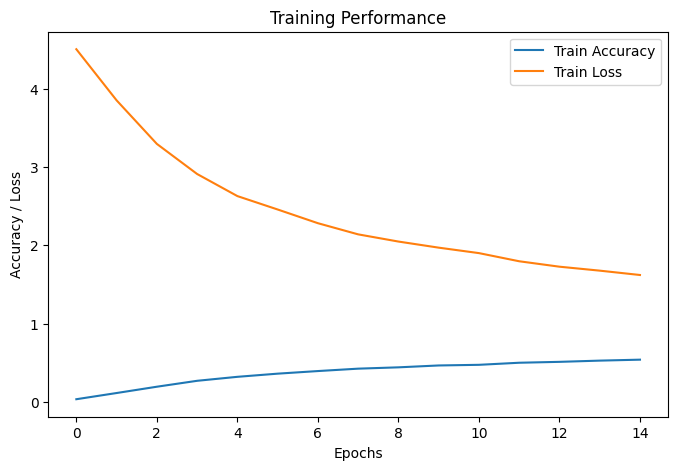

In [44]:
def plot_training_history(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy / Loss')
    plt.legend()
    plt.title('Training Performance')
    plt.show()

plot_training_history(history)

In [45]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
base_model.trainable = True  # Unfreeze the base model for fine-tuning
for layer in base_model.layers[:-60]:  # Freeze the initial layers
    layer.trainable = False



In [ ]:

# Recompiling the model with a lower learning rate

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [48]:

# Adding Callbacks

lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                 factor=0.5,
                                                 patience=3,
                                                 min_lr=1e-6)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=5,
                                               restore_best_weights=True)



In [49]:

epochs = 30
history = model.fit(train_dataset, epochs=epochs, callbacks=[lr_scheduler, early_stopping])



Epoch 1/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 76s 301ms/step - accuracy: 0.0085 - loss: 5.1024 - learning_rate: 1.0000e-04
Epoch 2/30


c:\Users\mjcul\Github\DataScience\venv\lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


228/228 ━━━━━━━━━━━━━━━━━━━━ 78s 339ms/step - accuracy: 0.0124 - loss: 4.6274 - learning_rate: 1.0000e-04
Epoch 3/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 72s 315ms/step - accuracy: 0.0095 - loss: 4.6219 - learning_rate: 1.0000e-04
Epoch 4/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 77s 336ms/step - accuracy: 0.0092 - loss: 4.6220 - learning_rate: 1.0000e-04
Epoch 5/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 74s 321ms/step - accuracy: 0.0087 - loss: 4.6212 - learning_rate: 1.0000e-04
Epoch 6/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 74s 324ms/step - accuracy: 0.0106 - loss: 4.6233 - learning_rate: 1.0000e-04
Epoch 7/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 75s 325ms/step - accuracy: 0.0100 - loss: 4.6188 - learning_rate: 1.0000e-04
Epoch 8/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 75s 327ms/step - accuracy: 0.0086 - loss: 4.6256 - learning_rate: 1.0000e-04
Epoch 9/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 71s 311ms/step - accuracy: 0.0105 - loss: 4.6202 - learning_rate: 1.0000e-04
Epoch 10/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 71s 310ms/step - accuracy: 0.0094 

KeyboardInterrupt: 

In [ ]:
# %%
# Evaluating the model

test_loss, test_acc = model.evaluate(train_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
plot_training_history(history)